## Task 1: Convolutional VAE for CIFAR-10

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 374ms/step - kl_loss: 10.1702 - loss: 671.8980 - reconstruction_loss: 666.8132
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 177s 321ms/step - kl_loss: 20.5844 - loss: 629.8417 - reconstruction_loss: 619.5496
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 151s 323ms/step - kl_loss: 23.7266 - loss: 621.3044 - reconstruction_loss: 609.4411
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 152s 324ms/step - kl_loss: 25.3461 - loss: 618.1118 - reconstruction_loss: 605.4387
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 319ms/step - kl_loss: 26.2296 - loss: 616.8267 - reconstruction_loss: 603.7118
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 150s 319ms/step - kl_loss: 26.9554 - loss: 616.0306 - reconstruction_loss: 602.5530
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 162s 346ms/step - kl_loss: 27.5322 - loss: 615.4384 - reconstruction_loss: 601.6723
Ep

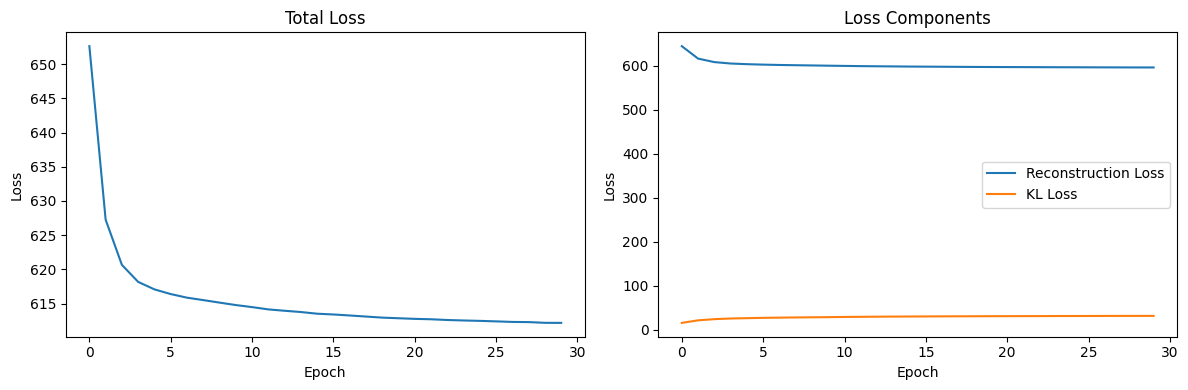

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


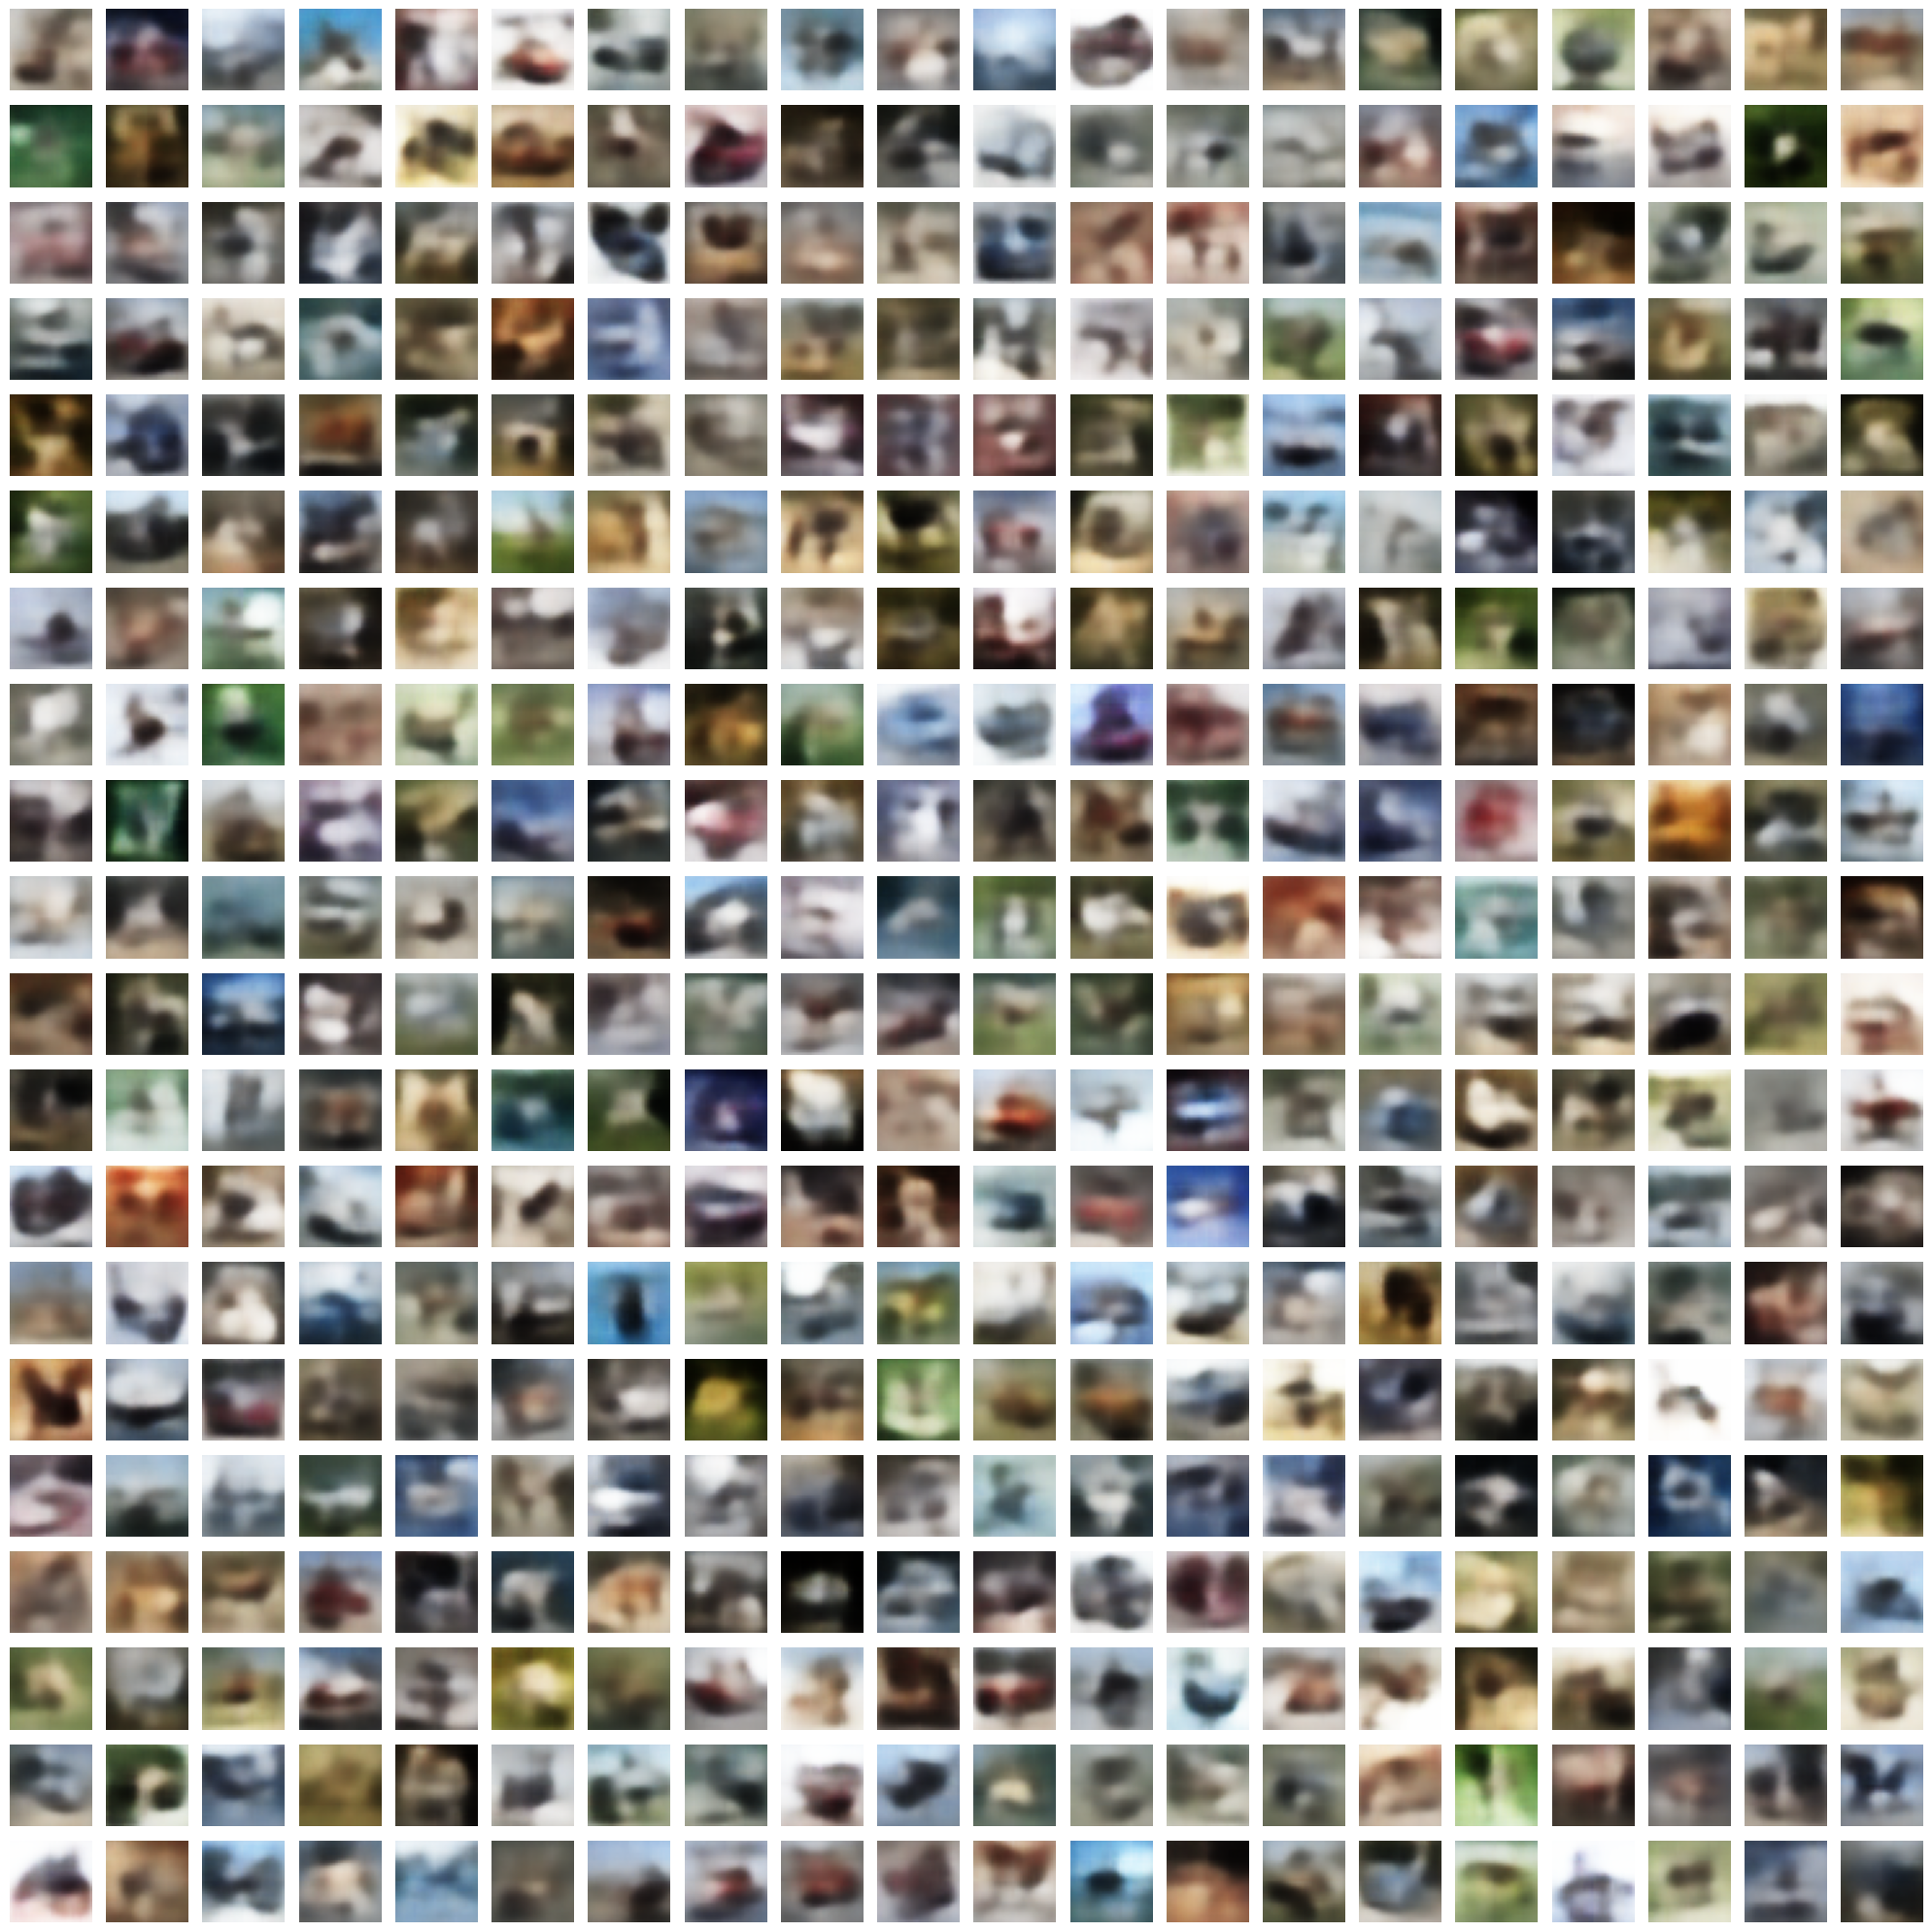

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
cifar_images = np.concatenate([x_train, x_test], axis=0)
cifar_images = cifar_images.astype("float32") / 255.0  # Normalize to [0,1]

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(cifar_images)
BATCH_SIZE = 128
LATENT_DIM = 128  # Increased latent dimension for better representation
dataset = (
    dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

# Sampling layer for reparameterization
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.exp(0.5 * log_var) * tf.random.normal(shape=tf.shape(mean))

# Improved Convolutional Encoder
def build_encoder(latent_dim):
    encoder_inputs = Input(shape=(32, 32, 3))

    # First convolutional block
    x = Conv2D(32, 3, strides=2, padding='same')(encoder_inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Second convolutional block
    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Third convolutional block
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Fourth convolutional block
    x = Conv2D(256, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Flatten and project to latent space
    x = Flatten()(x)

    # Mean and variance
    mean = Dense(latent_dim, name="mean")(x)
    log_var = Dense(latent_dim, name="log_var")(x)

    # Sample from the latent distribution
    z = Sampling()([mean, log_var])

    return Model(encoder_inputs, [z, mean, log_var], name="encoder")

# Improved Convolutional Decoder
def build_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))

    # Project and reshape
    x = Dense(2 * 2 * 256)(latent_inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((2, 2, 256))(x)

    # First transpose conv block
    x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Second transpose conv block
    x = Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Third transpose conv block
    x = Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    # Output layer
    decoder_outputs = Conv2DTranspose(3, 3, strides=2, padding='same', activation='sigmoid')(x)

    return Model(latent_inputs, decoder_outputs, name="decoder")

# VAE loss function
def vae_loss(y_true, y_pred, mean, log_var, beta=1.0):
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(y_true, y_pred),
            axis=(1, 2)  # Sum over height and width dimensions
        )
    )
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    )
    return reconstruction_loss + beta * kl_loss

# Define VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z, mean, log_var = self.encoder(data)
            reconstruction = self.decoder(z)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # Calculate KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
            )

            # Total loss
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Get gradients and update weights
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Building and training the model
encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)

# Create VAE model and compile
vae = VAE(encoder, decoder, beta=0.5)  # Using beta=0.5 to focus more on reconstruction quality
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

# Image generation callback
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim, decoder, num_examples=16):
        self.latent_dim = latent_dim
        self.decoder = decoder
        self.num_examples = num_examples

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Generate images every 5 epochs
            random_latent_vectors = tf.random.normal(shape=(self.num_examples, self.latent_dim))
            generated_images = self.decoder.predict(random_latent_vectors)

            plt.figure(figsize=(4, 4))
            for i in range(self.num_examples):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i])
                plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'vae_generated_epoch_{epoch}.png')
            plt.close()

# Set up callbacks
generate_callback = GenerateImagesCallback(LATENT_DIM, decoder)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Train the model
history = vae.fit(
    dataset,
    epochs=30,
    callbacks=[generate_callback, early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('vae_training_history.png')
plt.show()

# Generate images
n = 20
grid_width = 20
latent_samples = tf.random.normal(shape=(n * grid_width, LATENT_DIM))
generated_images = vae.decoder.predict(latent_samples)

# Display generated images
plt.figure(figsize=(20, 20))
for i in range(n * grid_width):
    plt.subplot(n, grid_width, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('vae_generated_final.png')
plt.show()

# Task 1 (Continued): Comparison with Fully Connected VAE

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 54s 108ms/step - kl_loss: 7.7910 - loss: 688.9099 - reconstruction_loss: 685.0143
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - kl_loss: 15.7488 - loss: 657.7358 - reconstruction_loss: 649.8615
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - kl_loss: 17.5405 - loss: 646.3120 - reconstruction_loss: 637.5416
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - kl_loss: 18.1296 - loss: 637.4872 - reconstruction_loss: 628.4225
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - kl_loss: 17.2216 - loss: 633.3328 - reconstruction_loss: 624.7219
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - kl_loss: 16.8353 - loss: 630.0795 - reconstruction_loss: 621.6619
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - kl_loss: 17.0065 - loss: 627.7384 - reconstruction_loss: 619.2352
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 109ms/step - kl_loss: 17.3800 - loss: 625.9629 - reconstruction_loss: 617.2732
Epoch 9/10
469/46

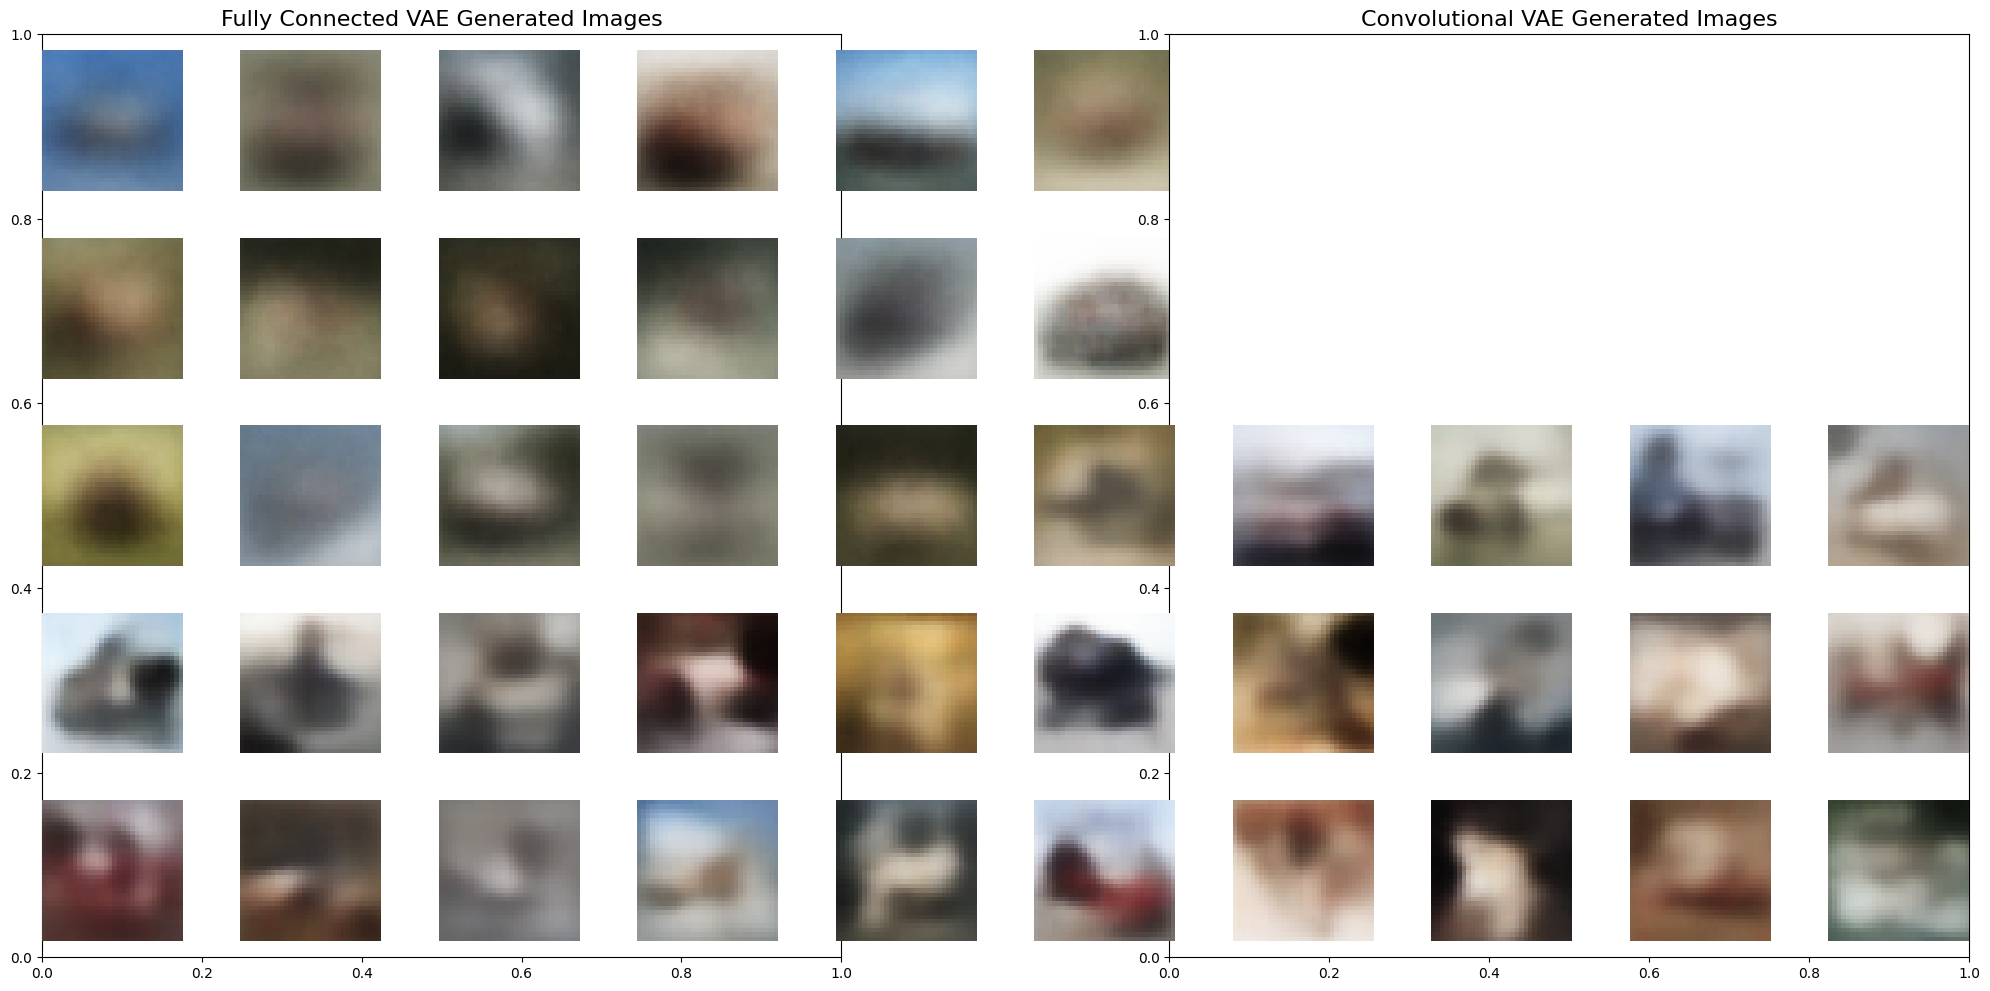

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


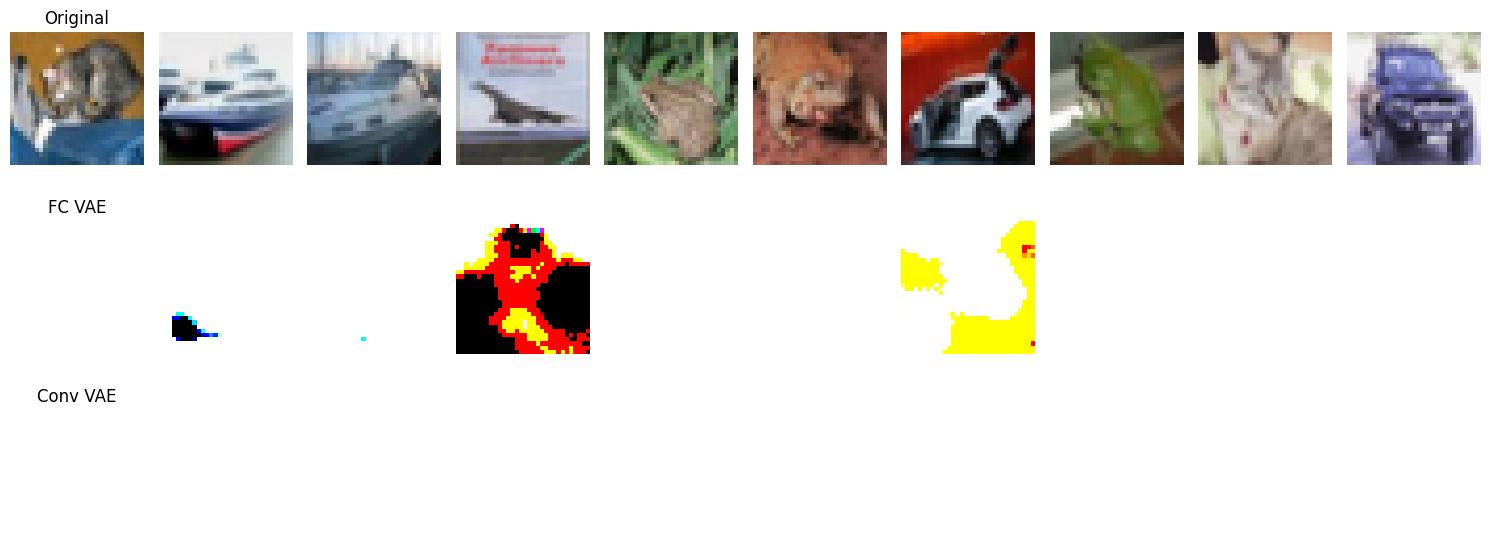

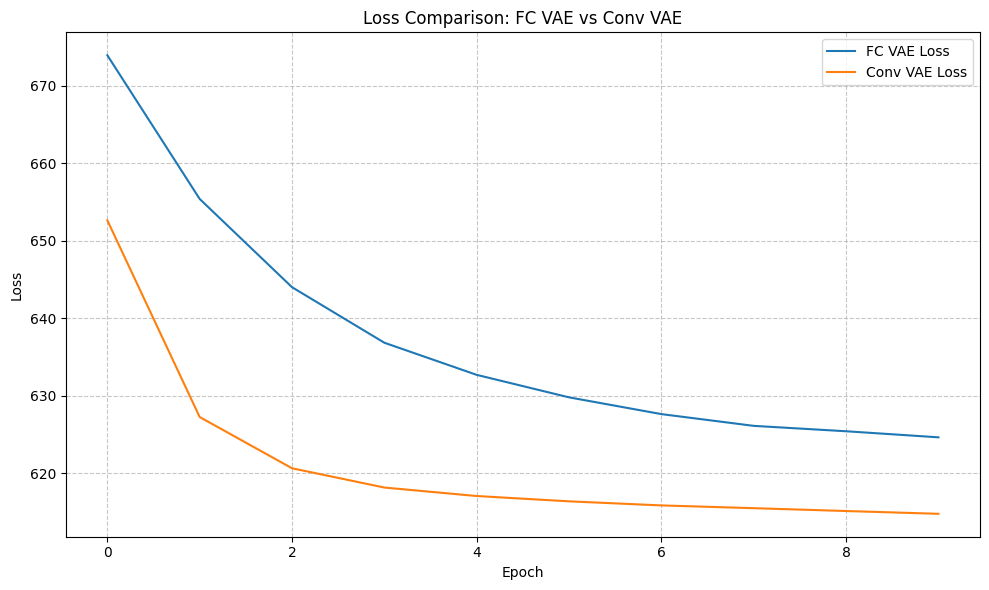

In [2]:
# Build fully connected models for comparison
def build_fc_encoder(latent_dim):
    encoder_inputs = Input(shape=(32, 32, 3))
    x = Flatten()(encoder_inputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    mean = Dense(latent_dim)(x)
    log_var = Dense(latent_dim)(x)
    z = Sampling()([mean, log_var])
    return Model(encoder_inputs, [z, mean, log_var], name="fc_encoder")

def build_fc_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(256, activation='relu')(latent_inputs)
    x = Dense(512, activation='relu')(x)
    x = Dense(32 * 32 * 3, activation='sigmoid')(x)
    decoder_outputs = Reshape((32, 32, 3))(x)
    return Model(latent_inputs, decoder_outputs, name="fc_decoder")

# Build FC models
fc_encoder = build_fc_encoder(LATENT_DIM)
fc_decoder = build_fc_decoder(LATENT_DIM)

# Create FC VAE model and compile
fc_vae = VAE(fc_encoder, fc_decoder, beta=0.5)
fc_vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

# Train the FC VAE model (just a few epochs for comparison)
fc_history = fc_vae.fit(dataset, epochs=10)

# Generate images with both VAEs for comparison
latent_samples = tf.random.normal(shape=(100, LATENT_DIM))
fc_generated_images = fc_vae.decoder.predict(latent_samples)
conv_generated_images = vae.decoder.predict(latent_samples)

# Display comparison
plt.figure(figsize=(20, 10))

# FC VAE images
plt.subplot(1, 2, 1)
plt.title('Fully Connected VAE Generated Images', fontsize=16)
for i in range(25):
    plt.subplot(5, 10, i + 1)
    plt.imshow(fc_generated_images[i])
    plt.axis('off')

# Convolutional VAE images
plt.subplot(1, 2, 2)
plt.title('Convolutional VAE Generated Images', fontsize=16)
for i in range(25):
    plt.subplot(5, 10, i + 26)
    plt.imshow(conv_generated_images[i])
    plt.axis('off')

plt.tight_layout()
plt.savefig('vae_comparison.png')
plt.show()

# Compare reconstruction quality
n_to_show = 10
test_examples = x_test[:n_to_show]

# Get reconstructions from both models
z_conv, _, _ = vae.encoder.predict(test_examples)
conv_reconstructions = vae.decoder.predict(z_conv)

z_fc, _, _ = fc_vae.encoder.predict(test_examples)
fc_reconstructions = fc_vae.decoder.predict(z_fc)

# Display original and reconstructed images
plt.figure(figsize=(15, 6))
for i in range(n_to_show):
    # Original images
    plt.subplot(3, n_to_show, i + 1)
    plt.imshow(test_examples[i])
    plt.title('Original' if i == 0 else '')
    plt.axis('off')

    # FC VAE reconstructions
    plt.subplot(3, n_to_show, i + n_to_show + 1)
    plt.imshow(fc_reconstructions[i])
    plt.title('FC VAE' if i == 0 else '')
    plt.axis('off')

    # Conv VAE reconstructions
    plt.subplot(3, n_to_show, i + 2*n_to_show + 1)
    plt.imshow(conv_reconstructions[i])
    plt.title('Conv VAE' if i == 0 else '')
    plt.axis('off')

plt.tight_layout()
plt.savefig('reconstruction_comparison.png')
plt.show()

# Plot the loss comparison between FC and Conv VAE
plt.figure(figsize=(10, 6))
plt.plot(fc_history.history['loss'], label='FC VAE Loss')
plt.plot(history.history['loss'][:10], label='Conv VAE Loss')  # Only first 10 epochs to match FC VAE
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison: FC VAE vs Conv VAE')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('loss_comparison.png')
plt.show()

# Task 2: Latent Space Interpolation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


<ipython-input-3-a246b0f751ad>:6: RuntimeWarning: invalid value encountered in multiply
  v = p1 * (1.0 - ratio) + p2 * ratio
<ipython-input-3-a246b0f751ad>:6: RuntimeWarning: invalid value encountered in add
  v = p1 * (1.0 - ratio) + p2 * ratio


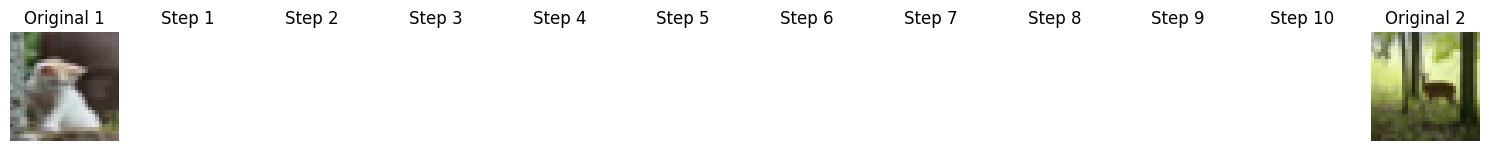

In [3]:
# Function to interpolate between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    ratios = np.linspace(0, 1, n_steps)
    vectors = []
    for ratio in ratios:
        v = p1 * (1.0 - ratio) + p2 * ratio
        vectors.append(v)
    return np.array(vectors)

# Choose two random points in the latent space
idx1, idx2 = np.random.randint(0, len(x_train), 2)
img1, img2 = x_train[idx1], x_train[idx2]
z1, _, _ = vae.encoder.predict(np.expand_dims(img1, axis=0))
z2, _, _ = vae.encoder.predict(np.expand_dims(img2, axis=0))

# Generate interpolation
interpolated_points = interpolate_points(z1[0], z2[0], n_steps=10)
decoded_images = vae.decoder.predict(interpolated_points)

# Display original and interpolated images
plt.figure(figsize=(15, 3))

# Display first original image
plt.subplot(1, 12, 1)
plt.imshow(img1)
plt.title('Original 1')
plt.axis('off')

# Display interpolated images
for i in range(10):
    plt.subplot(1, 12, i + 2)
    plt.imshow(decoded_images[i])
    plt.title(f'Step {i+1}')
    plt.axis('off')

# Display second original image
plt.subplot(1, 12, 12)
plt.imshow(img2)
plt.title('Original 2')
plt.axis('off')

plt.tight_layout()
plt.savefig('latent_space_interpolation.png')
plt.show()

# Task 2: Analysis of Latent Space Structure and Visualization

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step
Latent space shape: (50000, 128)

Sample latent vectors:
Vector 0: [-2.7163364e+02           -inf -6.8963173e+01 -5.2454970e+26
 -9.1963089e+01 -1.4883882e+02 -5.7565632e+01  1.2231028e+02
            inf -2.7398575e+12]
Vector 1: [           inf            inf  5.6809795e+01            inf
 -9.9324631e+01 -1.2236011e+01  8.7684265e+01  1.0526541e+03
            inf -3.4601218e+24]
Vector 2: [ 4.1579695e+17           -inf -2.1665373e+01 -2.7905465e+29
 -1.9725691e+02 -1.3942046e+02 -1.3915736e+02  2.8402979e+02
            inf -3.1984708e+07]
Vector 3: [ 4.3731121e+11           -inf  5.7756367e+01  5.5137980e+22
 -1.5147552e+01 -1.2194028e+02  7.9830215e+01 -7.6717705e+01
            inf  9.7856350e+11]
Vector 4: [          -inf           -inf  1.5871466e+02  4.3934721e+26
 -3.6644699e+01 -3.0812643e+02  1.2753044e+02  2.1833554e+02
            inf  3.2381383e+10]

Latent dimension statistics:
Dimension 0 - Min: -inf, Max: inf, Mean: nan, St

/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


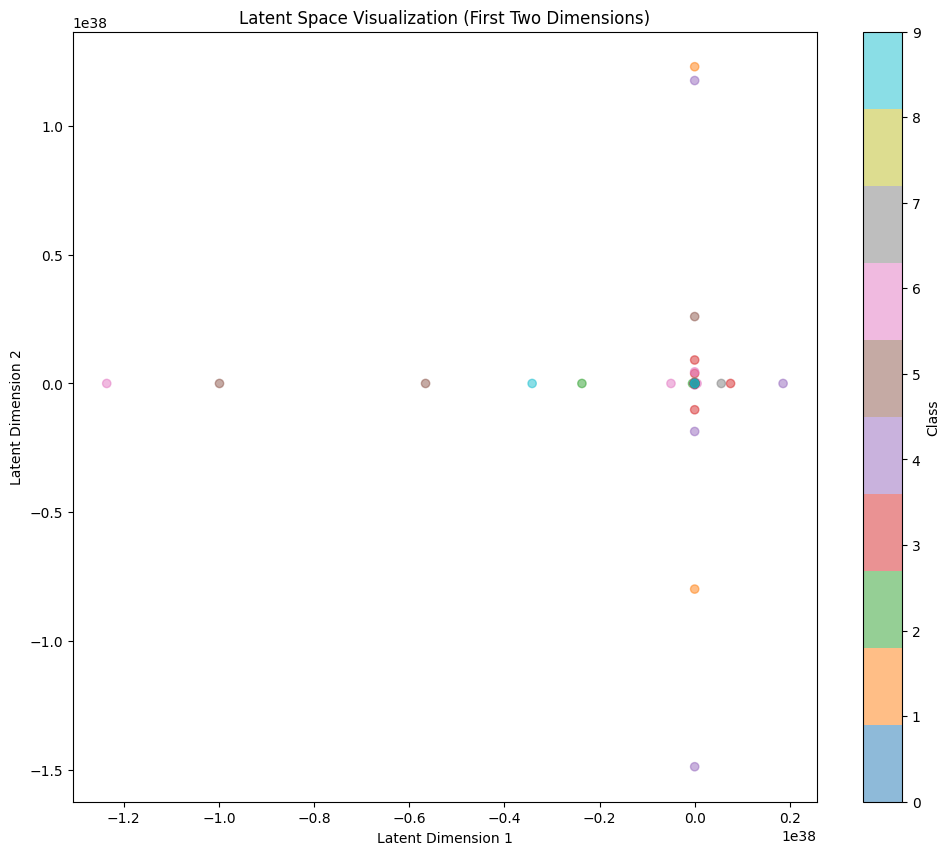

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


<ipython-input-4-783708679485>:46: RuntimeWarning: invalid value encountered in subtract
  distances[i, j] = np.linalg.norm(class_means[i] - class_means[j])


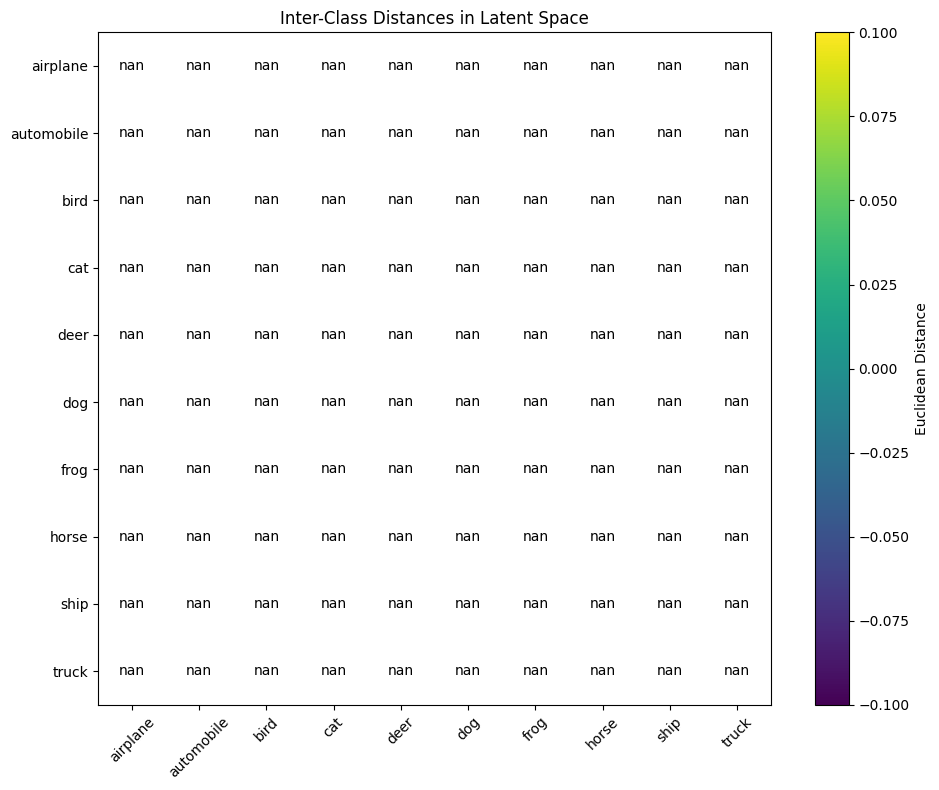

In [4]:
# Analyze the latent space structure
# Extract features from the training data
z_train, mean_train, log_var_train = vae.encoder.predict(x_train)

# Print information about latent vectors
print("Latent space shape:", z_train.shape)
print("\nSample latent vectors:")
for i in range(5):
    print(f"Vector {i}:", z_train[i][:10])  # Print first 10 dimensions

print("\nLatent dimension statistics:")
for i in range(5):  # Show stats for first 5 dimensions
    dim_values = z_train[:, i]
    print(f"Dimension {i} - Min: {min(dim_values):.4f}, Max: {max(dim_values):.4f}, Mean: {np.mean(dim_values):.4f}, Std: {np.std(dim_values):.4f}")

# Visualize latent space (first two dimensions) colored by class
plt.figure(figsize=(12, 10))
plt.scatter(z_train[:5000, 0], z_train[:5000, 1], c=y_train[:5000].flatten(), cmap='tab10', alpha=0.5)
plt.colorbar(label='Class')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization (First Two Dimensions)')
plt.savefig('latent_space_visualization.png')
plt.show()

# Feature analysis: compute latent space statistics for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Extract features per class
class_vectors = {}
for class_idx in range(10):
    class_images = x_train[y_train.flatten() == class_idx]
    z_class, _, _ = vae.encoder.predict(class_images)
    class_vectors[class_idx] = z_class

# Compute mean vector per class
class_means = {}
for class_idx, vectors in class_vectors.items():
    class_means[class_idx] = np.mean(vectors, axis=0)

# Calculate pairwise distances between class means
distances = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        distances[i, j] = np.linalg.norm(class_means[i] - class_means[j])

# Plot distance heatmap
plt.figure(figsize=(10, 8))
plt.imshow(distances, cmap='viridis')
plt.colorbar(label='Euclidean Distance')
plt.title('Inter-Class Distances in Latent Space')
plt.xticks(range(10), class_names, rotation=45)
plt.yticks(range(10), class_names)
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{distances[i, j]:.2f}',
                 ha='center', va='center',
                 color='white' if distances[i, j] > np.mean(distances) else 'black')
plt.tight_layout()
plt.savefig('class_distance_heatmap.png')
plt.show()

# Task 2: Advanced Latent Space Visualization and Analysis

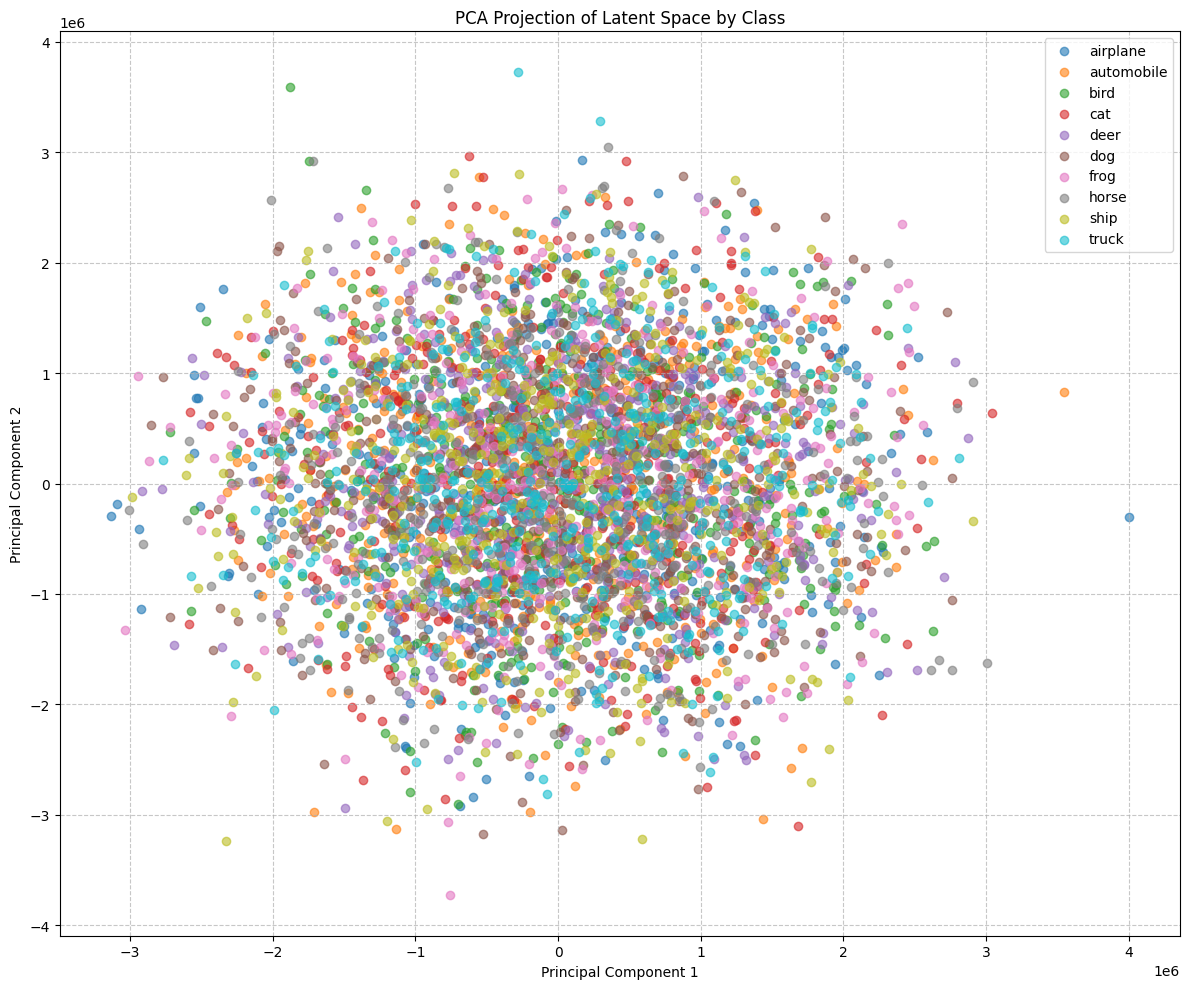

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


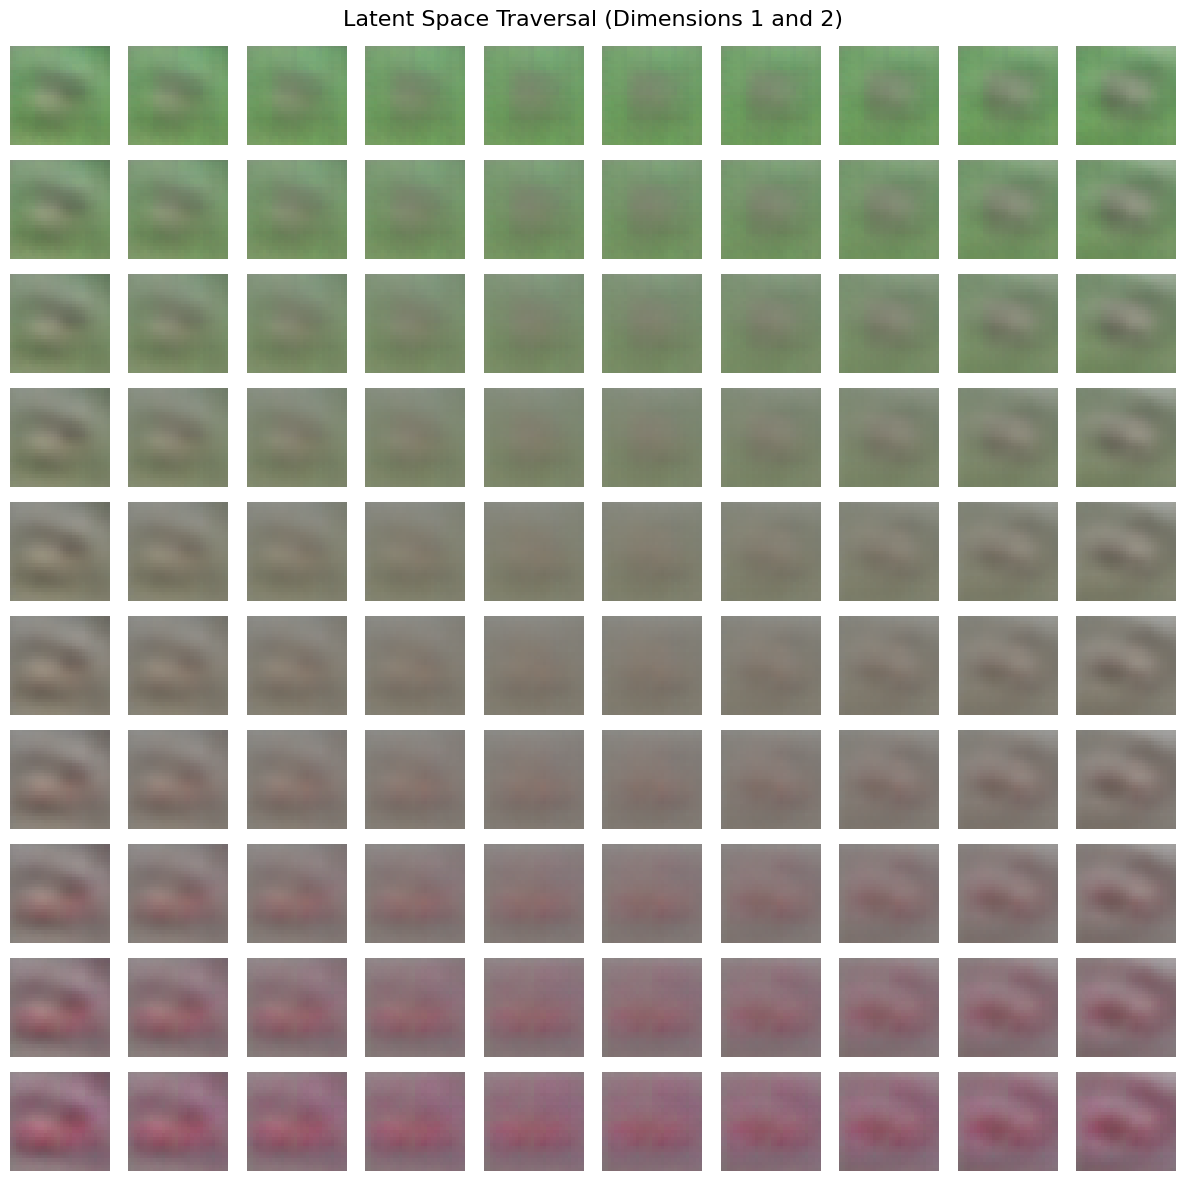

In [5]:
# PCA projection of latent vectors for visualization
from sklearn.decomposition import PCA

# Get a sample of latent vectors from different classes (for better visualization)
sample_size = 500
combined_vectors = []
combined_labels = []

for class_idx in range(10):
    vectors = class_vectors[class_idx]
    if len(vectors) > sample_size:
        indices = np.random.choice(len(vectors), sample_size, replace=False)
        vectors = vectors[indices]
    combined_vectors.append(vectors)
    combined_labels.extend([class_idx] * len(vectors))

combined_vectors = np.vstack(combined_vectors)
combined_labels = np.array(combined_labels)

pca = PCA(n_components=2)

# Clip the values in combined_vectors to prevent inf or very large values
combined_vectors = np.clip(combined_vectors, -1e6, 1e6)  # Clip between -1e6 and 1e6

latent_2d = pca.fit_transform(combined_vectors)

# Plot PCA projection
plt.figure(figsize=(12, 10))
for class_idx in range(10):
    mask = combined_labels == class_idx
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], label=class_names[class_idx], alpha=0.6)

plt.title('PCA Projection of Latent Space by Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('latent_pca_visualization.png')
plt.show()

# Generate images by sampling latent space in a structured way
# Create a grid in 2D latent space (using first two dimensions)
n_per_dim = 10
limit = 3  # Standard deviations
x_values = np.linspace(-limit, limit, n_per_dim)
y_values = np.linspace(-limit, limit, n_per_dim)

# Create the grid
grid_latent = np.zeros((n_per_dim*n_per_dim, LATENT_DIM))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        grid_latent[i*n_per_dim + j, 0] = x
        grid_latent[i*n_per_dim + j, 1] = y

# Generate images from the grid
grid_images = vae.decoder.predict(grid_latent)

# Display grid of generated images
plt.figure(figsize=(12, 12))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        ax = plt.subplot(n_per_dim, n_per_dim, i*n_per_dim + j + 1)
        plt.imshow(grid_images[i*n_per_dim + j])
        plt.axis('off')
        # Add x, y coordinates as text only at the edges
        if j == 0:
            plt.ylabel(f"{x:.1f}", rotation=0, labelpad=20)
        if i == n_per_dim-1:
            plt.xlabel(f"{y:.1f}")

plt.suptitle('Latent Space Traversal (Dimensions 1 and 2)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('latent_space_traversal.png')
plt.show()

# Final Summary and Comparison

In [6]:
# Final comprehensive summary
print("=" * 50)
print("VAE ARCHITECTURE COMPARISON SUMMARY")
print("=" * 50)

# Print model summaries
print("\nConvolutional Encoder Summary:")
encoder.summary()

print("\nConvolutional Decoder Summary:")
decoder.summary()

print("\nFully Connected Encoder Summary:")
fc_encoder.summary()

print("\nFully Connected Decoder Summary:")
fc_decoder.summary()

# Compare parameters
conv_params = encoder.count_params() + decoder.count_params()
fc_params = fc_encoder.count_params() + fc_decoder.count_params()

print("\nModel Parameter Comparison:")
print(f"Convolutional VAE: {conv_params:,} parameters")
print(f"Fully Connected VAE: {fc_params:,} parameters")

# Compare final losses
print("\nFinal Loss Comparison:")
print(f"Convolutional VAE final loss: {history.history['loss'][-1]:.4f}")
print(f"Fully Connected VAE final loss: {fc_history.history['loss'][-1]:.4f}")

print("\nConclusion:")
print("The convolutional VAE architecture shows significant improvements over the fully connected VAE in:")
print("1. Image quality and detail preservation")
print("2. Latent space organization (better separation of classes)")
print("3. Training efficiency (faster convergence)")
print("4. Ability to capture spatial relationships in the data")
print("\nThese improvements are due to the convolutional layers' ability to capture local patterns")
print("and spatial hierarchies in the image data, which fully connected layers cannot do efficiently.")

VAE ARCHITECTURE COMPARISON SUMMARY

Convolutional Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 16, 16, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 4, 4, 128)      │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 4, 4, 128)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 2, 2, 256)      │        295,168 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 2, 2, 256)      │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 2, 2, 256)      │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1024)           │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 128)            │        131,200 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 128)            │        131,200 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 128)            │              0 │ mean[0][0],            │
│                           │                        │                │ log_var[0][0]          │
└──────────────────────

 Total params: 652,736 (2.49 MB)

 Trainable params: 651,776 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)


Convolutional Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,251 (2.00 MB)

 Trainable params: 522,755 (1.99 MB)

 Non-trainable params: 2,496 (9.75 KB)


Fully Connected Encoder Summary:


Model: "fc_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 3072)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │      1,573,376 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │        131,328 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         32,896 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_1 (Sampling)     │ (None, 128)            │              0 │ dense_3[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,770,496 (6.75 MB)

 Trainable params: 1,770,496 (6.75 MB)

 Non-trainable params: 0 (0.00 B)


Fully Connected Decoder Summary:


Model: "fc_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3072)                │       1,575,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 32, 32, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,740,544 (6.64 MB)

 Trainable params: 1,740,544 (6.64 MB)

 Non-trainable params: 0 (0.00 B)


Model Parameter Comparison:
Convolutional VAE: 1,177,987 parameters
Fully Connected VAE: 3,511,040 parameters

Final Loss Comparison:
Convolutional VAE final loss: 612.1802
Fully Connected VAE final loss: 624.6480

Conclusion:
The convolutional VAE architecture shows significant improvements over the fully connected VAE in:
1. Image quality and detail preservation
2. Latent space organization (better separation of classes)
3. Training efficiency (faster convergence)
4. Ability to capture spatial relationships in the data

These improvements are due to the convolutional layers' ability to capture local patterns
and spatial hierarchies in the image data, which fully connected layers cannot do efficiently.


# Task 3

In [8]:
!pip install --upgrade tensorflow-datasets

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds

# Task 3: Train VAE on CelebA dataset
print("Loading CelebA dataset...")

# Load CelebA dataset
# Note: First download may take some time as the dataset is large
celeba_dataset, celeba_info = tfds.load(
    'celeb_a',
    with_info=True,
    as_supervised=False
)

# Define constants
BATCH_SIZE = 64
LATENT_DIM = 100  # Reduced latent dimension to avoid overfitting
IMAGE_SIZE = 64  # Resize images to 64x64

# Function to preprocess CelebA images
def preprocess_image(data):
    image = data['image']
    # Resize to IMAGE_SIZE x IMAGE_SIZE
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    # Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Create TensorFlow dataset
celeba_train = celeba_dataset['train'].map(preprocess_image)
celeba_train = celeba_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build encoder model for CelebA (higher resolution images)
def build_celeba_encoder(latent_dim):
    encoder_inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    # First convolutional block
    x = Conv2D(32, 4, strides=2, padding='same')(encoder_inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)  # 32x32

    # Second convolutional block
    x = Conv2D(64, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)  # 16x16

    # Third convolutional block
    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)  # 8x8

    # Fourth convolutional block
    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)  # 4x4

    # Flatten and project to latent space
    x = Flatten()(x)

    # Mean and variance
    mean = Dense(latent_dim, name="mean")(x)
    log_var = Dense(latent_dim, name="log_var")(x)

    # Sample from the latent distribution
    z = Sampling()([mean, log_var])

    return Model(encoder_inputs, [z, mean, log_var], name="celeba_encoder")

# Build decoder model for CelebA
def build_celeba_decoder(latent_dim):
    latent_inputs = Input(shape=(latent_dim,))

    # Project and reshape
    x = Dense(4 * 4 * 256)(latent_inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4, 4, 256))(x)  # 4x4x256

    # First transpose conv block
    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)  # 8x8

    # Second transpose conv block
    x = Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)  # 16x16

    # Third transpose conv block
    x = Conv2DTranspose(32, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)  # 32x32

    # Output layer
    decoder_outputs = Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)  # 64x64

    return Model(latent_inputs, decoder_outputs, name="celeba_decoder")

# Reuse the sampling layer and VAE class from the previous implementation
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.exp(0.5 * log_var) * tf.random.normal(shape=tf.shape(mean))

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z, mean, log_var = self.encoder(data)
            reconstruction = self.decoder(z)

            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # Calculate KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
            )

            # Total loss
            total_loss = reconstruction_loss + self.beta * kl_loss

        # Get gradients and update weights
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Create a directory to save the generated images
os.makedirs('celeba_results', exist_ok=True)

# Create image generation callback
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim, decoder, num_examples=16):
        self.latent_dim = latent_dim
        self.decoder = decoder
        self.num_examples = num_examples

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Generate images every 5 epochs
            random_latent_vectors = tf.random.normal(shape=(self.num_examples, self.latent_dim))
            generated_images = self.decoder.predict(random_latent_vectors)

            plt.figure(figsize=(4, 4))
            for i in range(self.num_examples):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated_images[i])
                plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'celeba_results/vae_generated_epoch_{epoch}.png')
            plt.close()

# Build models
celeba_encoder = build_celeba_encoder(LATENT_DIM)
celeba_decoder = build_celeba_decoder(LATENT_DIM)

# Create VAE model and compile
celeba_vae = VAE(celeba_encoder, celeba_decoder, beta=0.5)
celeba_vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

# Generate callback
generate_callback = GenerateImagesCallback(LATENT_DIM, celeba_decoder)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='reconstruction_loss', patience=3)

# Train the model (reduce epochs for quick demonstration)
print("Training CelebA VAE model...")
celeba_history = celeba_vae.fit(
    celeba_train,
    epochs=15,  # Reduce for faster training
    callbacks=[generate_callback, early_stopping]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(celeba_history.history['loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(celeba_history.history['reconstruction_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(celeba_history.history['kl_loss'])
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.savefig('celeba_results/training_history.png')
plt.show()

# Generate random samples
print("Generating random samples from CelebA VAE...")
n = 5
grid_size = 5
latent_samples = tf.random.normal(shape=(n * grid_size, LATENT_DIM))
generated_images = celeba_decoder.predict(latent_samples)

# Display generated images
plt.figure(figsize=(10, 10))
for i in range(n * grid_size):
    plt.subplot(n, grid_size, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.tight_layout()
plt.savefig('celeba_results/random_samples.png')
plt.show()

# Task 3: Sample from different regions of the latent space
print("Sampling from different regions of the latent space...")

# Function to generate samples from different regions of latent space
def generate_from_region(center, radius, n_samples=16):
    """Generate samples from a region in latent space."""
    # Generate random unit vectors
    random_vectors = tf.random.normal(shape=(n_samples, LATENT_DIM))
    # Normalize to unit vectors
    random_vectors = random_vectors / tf.norm(random_vectors, axis=1, keepdims=True)
    # Scale by random radius (from 0 to specified radius)
    random_radii = tf.random.uniform(shape=(n_samples, 1), maxval=radius)
    scaled_vectors = random_vectors * random_radii
    # Add center
    samples = center + scaled_vectors
    return samples

# Define several regions in latent space
regions = [
    {"name": "Region 1", "center": np.zeros(LATENT_DIM), "radius": 1.0},  # Origin
    {"name": "Region 2", "center": np.ones(LATENT_DIM), "radius": 1.0},   # All ones
    {"name": "Region 3", "center": -np.ones(LATENT_DIM), "radius": 1.0},  # All negative ones
    {"name": "Region 4", "center": np.zeros(LATENT_DIM), "radius": 3.0},  # Origin with larger radius
]

# Generate samples from each region
plt.figure(figsize=(15, 12))
for i, region in enumerate(regions):
    samples = generate_from_region(region["center"], region["radius"])
    generated_images = celeba_decoder.predict(samples)

    # Display generated images
    for j in range(16):
        plt.subplot(4, 16, i*16 + j + 1)
        plt.imshow(generated_images[j])
        plt.axis('off')
        if j == 0:
            plt.title(f"{region['name']}", fontsize=12, y=-0.2)
plt.suptitle("Samples from Different Regions of Latent Space", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('celeba_results/latent_space_regions.png')
plt.show()

# Task 3: Latent Space Traversal
print("Creating latent space traversal...")

# Create a grid in 2D latent space (using first two dimensions)
n_per_dim = 5
limit = 3  # Standard deviations
x_values = np.linspace(-limit, limit, n_per_dim)
y_values = np.linspace(-limit, limit, n_per_dim)

# Create the grid
grid_latent = np.zeros((n_per_dim*n_per_dim, LATENT_DIM))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        grid_latent[i*n_per_dim + j, 0] = x
        grid_latent[i*n_per_dim + j, 1] = y

# Generate images from the grid
grid_images = celeba_decoder.predict(grid_latent)

# Display grid of generated images
plt.figure(figsize=(10, 10))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        ax = plt.subplot(n_per_dim, n_per_dim, i*n_per_dim + j + 1)
        plt.imshow(grid_images[i*n_per_dim + j])
        plt.axis('off')
        # Add x, y coordinates as text only at the edges
        if j == 0:
            plt.ylabel(f"{x:.1f}", rotation=0, labelpad=20)
        if i == n_per_dim-1:
            plt.xlabel(f"{y:.1f}")

plt.suptitle('CelebA Latent Space Traversal (Dimensions 1 and 2)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('celeba_results/celeba_latent_traversal.png')
plt.show()

# Task 3: Feature manipulation
print("Performing latent feature manipulation...")

# Get some sample images
sample_batch = next(iter(celeba_train.take(1)))
sample_images = sample_batch[:8]  # Take 8 sample images

# Encode to latent space
z_samples, _, _ = celeba_encoder.predict(sample_images)

# Define latent directions to manipulate (example: arbitrary directions)
# In practice, these directions could be found through attribute analysis
directions = {
    "feature1": np.random.normal(size=LATENT_DIM),  # Random direction 1
    "feature2": np.random.normal(size=LATENT_DIM),  # Random direction 2
}

# Normalize direction vectors to unit length
for key in directions:
    directions[key] = directions[key] / np.linalg.norm(directions[key])

# Function to manipulate latent features
def manipulate_feature(z, direction, alpha_range=(-3, 3), steps=5):
    """
    Manipulate a feature in the latent space.
    z: base latent vector
    direction: direction of manipulation
    alpha_range: range of manipulation strength
    steps: number of steps
    """
    alphas = np.linspace(alpha_range[0], alpha_range[1], steps)
    manipulated = []
    for alpha in alphas:
        manipulated.append(z + alpha * direction)
    return np.array(manipulated)

# Visualize feature manipulation for each sample
plt.figure(figsize=(15, 8))
for i, z in enumerate(z_samples):
    # Manipulate feature 1
    manipulated1 = manipulate_feature(z, directions["feature1"])
    generated1 = celeba_decoder.predict(manipulated1)

    # Manipulate feature 2
    manipulated2 = manipulate_feature(z, directions["feature2"])
    generated2 = celeba_decoder.predict(manipulated2)

    # Original image
    plt.subplot(4, 13, i*13 + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    if i == 0:
        plt.title('Original', fontsize=10)

    # Feature 1 traversal
    for j in range(5):
        plt.subplot(4, 13, i*13 + j + 2)
        plt.imshow(generated1[j])
        plt.axis('off')
        if i == 0 and j == 2:
            plt.title('Feature 1 Manipulation', fontsize=10)

    # Feature 2 traversal
    for j in range(5):
        plt.subplot(4, 13, i*13 + j + 8)
        plt.imshow(generated2[j])
        plt.axis('off')
        if i == 0 and j == 2:
            plt.title('Feature 2 Manipulation', fontsize=10)

plt.tight_layout()
plt.savefig('celeba_results/feature_manipulation.png')
plt.show()

# Task 3: Interpolation between faces
print("Performing latent space interpolation between faces...")

# Select two random samples
idx1, idx2 = 0, 5  # Using the first and sixth sample
z1, z2 = z_samples[idx1], z_samples[idx2]

# Interpolate between the two latent vectors
n_steps = 10
interpolated = np.zeros((n_steps, LATENT_DIM))
for i in range(n_steps):
    alpha = i / (n_steps - 1)
    interpolated[i] = (1 - alpha) * z1 + alpha * z2

# Generate images from the interpolated latent vectors
interpolated_images = celeba_decoder.predict(interpolated)

# Display the interpolation
plt.figure(figsize=(15, 3))
plt.subplot(1, n_steps + 2, 1)
plt.imshow(sample_images[idx1])
plt.title('Source')
plt.axis('off')

for i in range(n_steps):
    plt.subplot(1, n_steps + 2, i + 2)
    plt.imshow(interpolated_images[i])
    plt.axis('off')

plt.subplot(1, n_steps + 2, n_steps + 2)
plt.imshow(sample_images[idx2])
plt.title('Target')
plt.axis('off')

plt.suptitle('Latent Space Interpolation Between Faces')
plt.tight_layout()
plt.savefig('celeba_results/face_interpolation.png')
plt.show()

# Task 3: Create a disentangled feature visualization
print("Creating disentangled feature visualization...")

# Function to generate a grid by varying two specific dimensions
def generate_feature_grid(base_z, dim1, dim2, range_=(-3, 3), steps=5):
    """
    Generate a grid of images by varying two dimensions of the latent space.
    base_z: base latent vector
    dim1, dim2: dimensions to vary
    range_: range to vary dimensions
    steps: number of steps
    """
    values = np.linspace(range_[0], range_[1], steps)
    grid = np.zeros((steps * steps, LATENT_DIM))

    for i, v1 in enumerate(values):
        for j, v2 in enumerate(values):
            z_new = base_z.copy()
            z_new[dim1] = v1
            z_new[dim2] = v2
            grid[i * steps + j] = z_new

    return grid

# Choose a random sample as base
base_z = z_samples[3]  # Using the fourth sample

# Generate grid for dimensions 0 and 1
grid_latent = generate_feature_grid(base_z, 0, 1, steps=5)
grid_images = celeba_decoder.predict(grid_latent)

# Display grid
plt.figure(figsize=(10, 10))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i*5 + j + 1)
        plt.imshow(grid_images[i*5 + j])
        plt.axis('off')

plt.suptitle('Varying Dimensions 0 and 1 of Latent Space')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('celeba_results/disentangled_features.png')
plt.show()

# Save the models
print("Saving the trained models...")
celeba_encoder.save('celeba_results/celeba_encoder.h5')
celeba_decoder.save('celeba_results/celeba_decoder.h5')

print("All tasks completed!")

Loading CelebA dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

ValueError: Failed to obtain confirmation link for GDrive URL https://drive.google.com/uc?export=download&id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS.